# Imports

In [8]:
import os
import sys
import pandas as pd
import numpy as np
import tensorflow as tf

# Append source directory to path
sys.path.append("../../src/")

# Import custom modules
from ECALDataAnalyzer import ECALDataAnalyzer
from TrainData import load_train_test_data
from model_functions import make_gravnet_model
from loss_functions import CustomLoss, AttractiveLossMetric, RepulsiveLossMetric, CowardLossMetric, NoiseLossMetric
from ModelEcalPlotter import ModelEcalPlotter
from Evaluator import Evaluator
from callbacks import PlotCallback, CyclicalLearningRate, LossPlotCallback
from helper_functions import create_output_directory, create_gif_from_pngs

In [10]:
import tensorflow as tf

# Load Data

In [7]:
project_directory = '../../projects/nightly.08.28.2024.21.04/training/'
(train_X, train_y, train_misc), (test_X, test_y, test_misc) = load_train_test_data(project_directory)

train_X=train_X[:10000]
train_y=train_y[:10000]
train_misc=train_misc[:10000]


test_X=test_X[:10000]
test_y=test_y[:10000]
test_misc=test_misc[:10000]


Testing data loaded from ../../projects/nightly.08.28.2024.21.04/training/dataset_test.h5
Training data loaded from ../../projects/nightly.08.28.2024.21.04/training/dataset_train.h5


# GravNet Model

In [4]:
# Set training parameters
batch_size = 128         # Batch size
initial_lr = 1e-6       # Initial learning rate for CLR
max_lr = 1e-5           # Maximum learning rate for CLR
step_size = 20          # 20 batches for half cycle, so 40 batches for a full cycle
N_epochs = 100          # Number of epochs to train
q_min = 0.1             # q_min for the custom loss
tB = 0.1                # Minimum beta for clustering
tD = 0.25               # Minimum distance for clustering
ev = 1200               # Event number to plot

# Produce new output directory for saving plots
outdir = create_output_directory("./out")

# Define the model
model = make_gravnet_model(
    K=train_X.shape[1],
    N_feat=train_X.shape[2],
    N_grav_layers=2,
    N_neighbors=10,
    N_filters=64
)

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)

# Instantiate the custom loss function
custom_loss = CustomLoss(q_min=q_min)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=custom_loss,
    metrics=[
        AttractiveLossMetric(q_min=q_min),
        RepulsiveLossMetric(q_min=q_min),
        CowardLossMetric(q_min=q_min),
        NoiseLossMetric(q_min=q_min)
    ]
)

# Callbacks
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

clr_callback = CyclicalLearningRate(
    initial_learning_rate=initial_lr, 
    max_learning_rate=max_lr, 
    step_size=step_size
)

ecal_plot_callback = PlotCallback(
    X=train_X[ev:ev+10],
    y=train_y[ev:ev+10],
    misc=train_misc[ev:ev+10],
    tB=tB,
    tD=tD,
    outdir=outdir
)

loss_plot_callback = LossPlotCallback(
    save_path=f"{outdir}/loss.png"
)

# Output the number of parameters in the model
print("Number of Parameters:", model.count_params())

Number of Parameters: 35539


/opt/conda/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [5]:
# Train the model
history = model.fit(x=train_X,
                    y=train_y,
                    batch_size=batch_size,
                    epochs=N_epochs,
                    shuffle=True,
                    validation_data=(test_X, test_y),
                    callbacks=[#early_stopping_callback,
                               #clr_callback,
                               #ecal_plot_callback,
                               #loss_plot_callback
                    ])

Epoch 1/100
51/79 [==================>...........] - ETA: 1s - loss: 2.6491 - attractive_loss: 1.7423 - repulsive_loss: 0.0152 - coward_loss: 0.3754 - noise_loss: 0.5162

KeyboardInterrupt: 

In [7]:
#evaluator = Evaluator(test_X[:100], test_y[:100], test_misc[:100])
evaluator = Evaluator(train_X[:100], train_y[:100], train_misc[:100])
#evaluator = Evaluator(train_X[:1], train_y[:1], train_misc[:1])

evaluator.load_model(model)
evaluator.predict()
evaluator.cluster(0.2,0.42)

4/4 [==============================] - 0s 8ms/step


Randomly generated event number = 43


array([<Axes: xlabel='ECAL::peaks (X)', ylabel='ECAL::peaks (Y)'>,
       <Axes: xlabel='Latent X Coordinate', ylabel='Latent Y Coordinate'>,
       <Axes: xlabel='ECAL::peaks (X)', ylabel='ECAL::peaks (Y)'>,
       <Axes: xlabel='ECAL::peaks (X)', ylabel='ECAL::peaks (Y)'>,
       <Axes: xlabel='Latent X Coordinate', ylabel='Latent Y Coordinate'>,
       <Axes: xlabel='Learned $\\beta$'>], dtype=object)

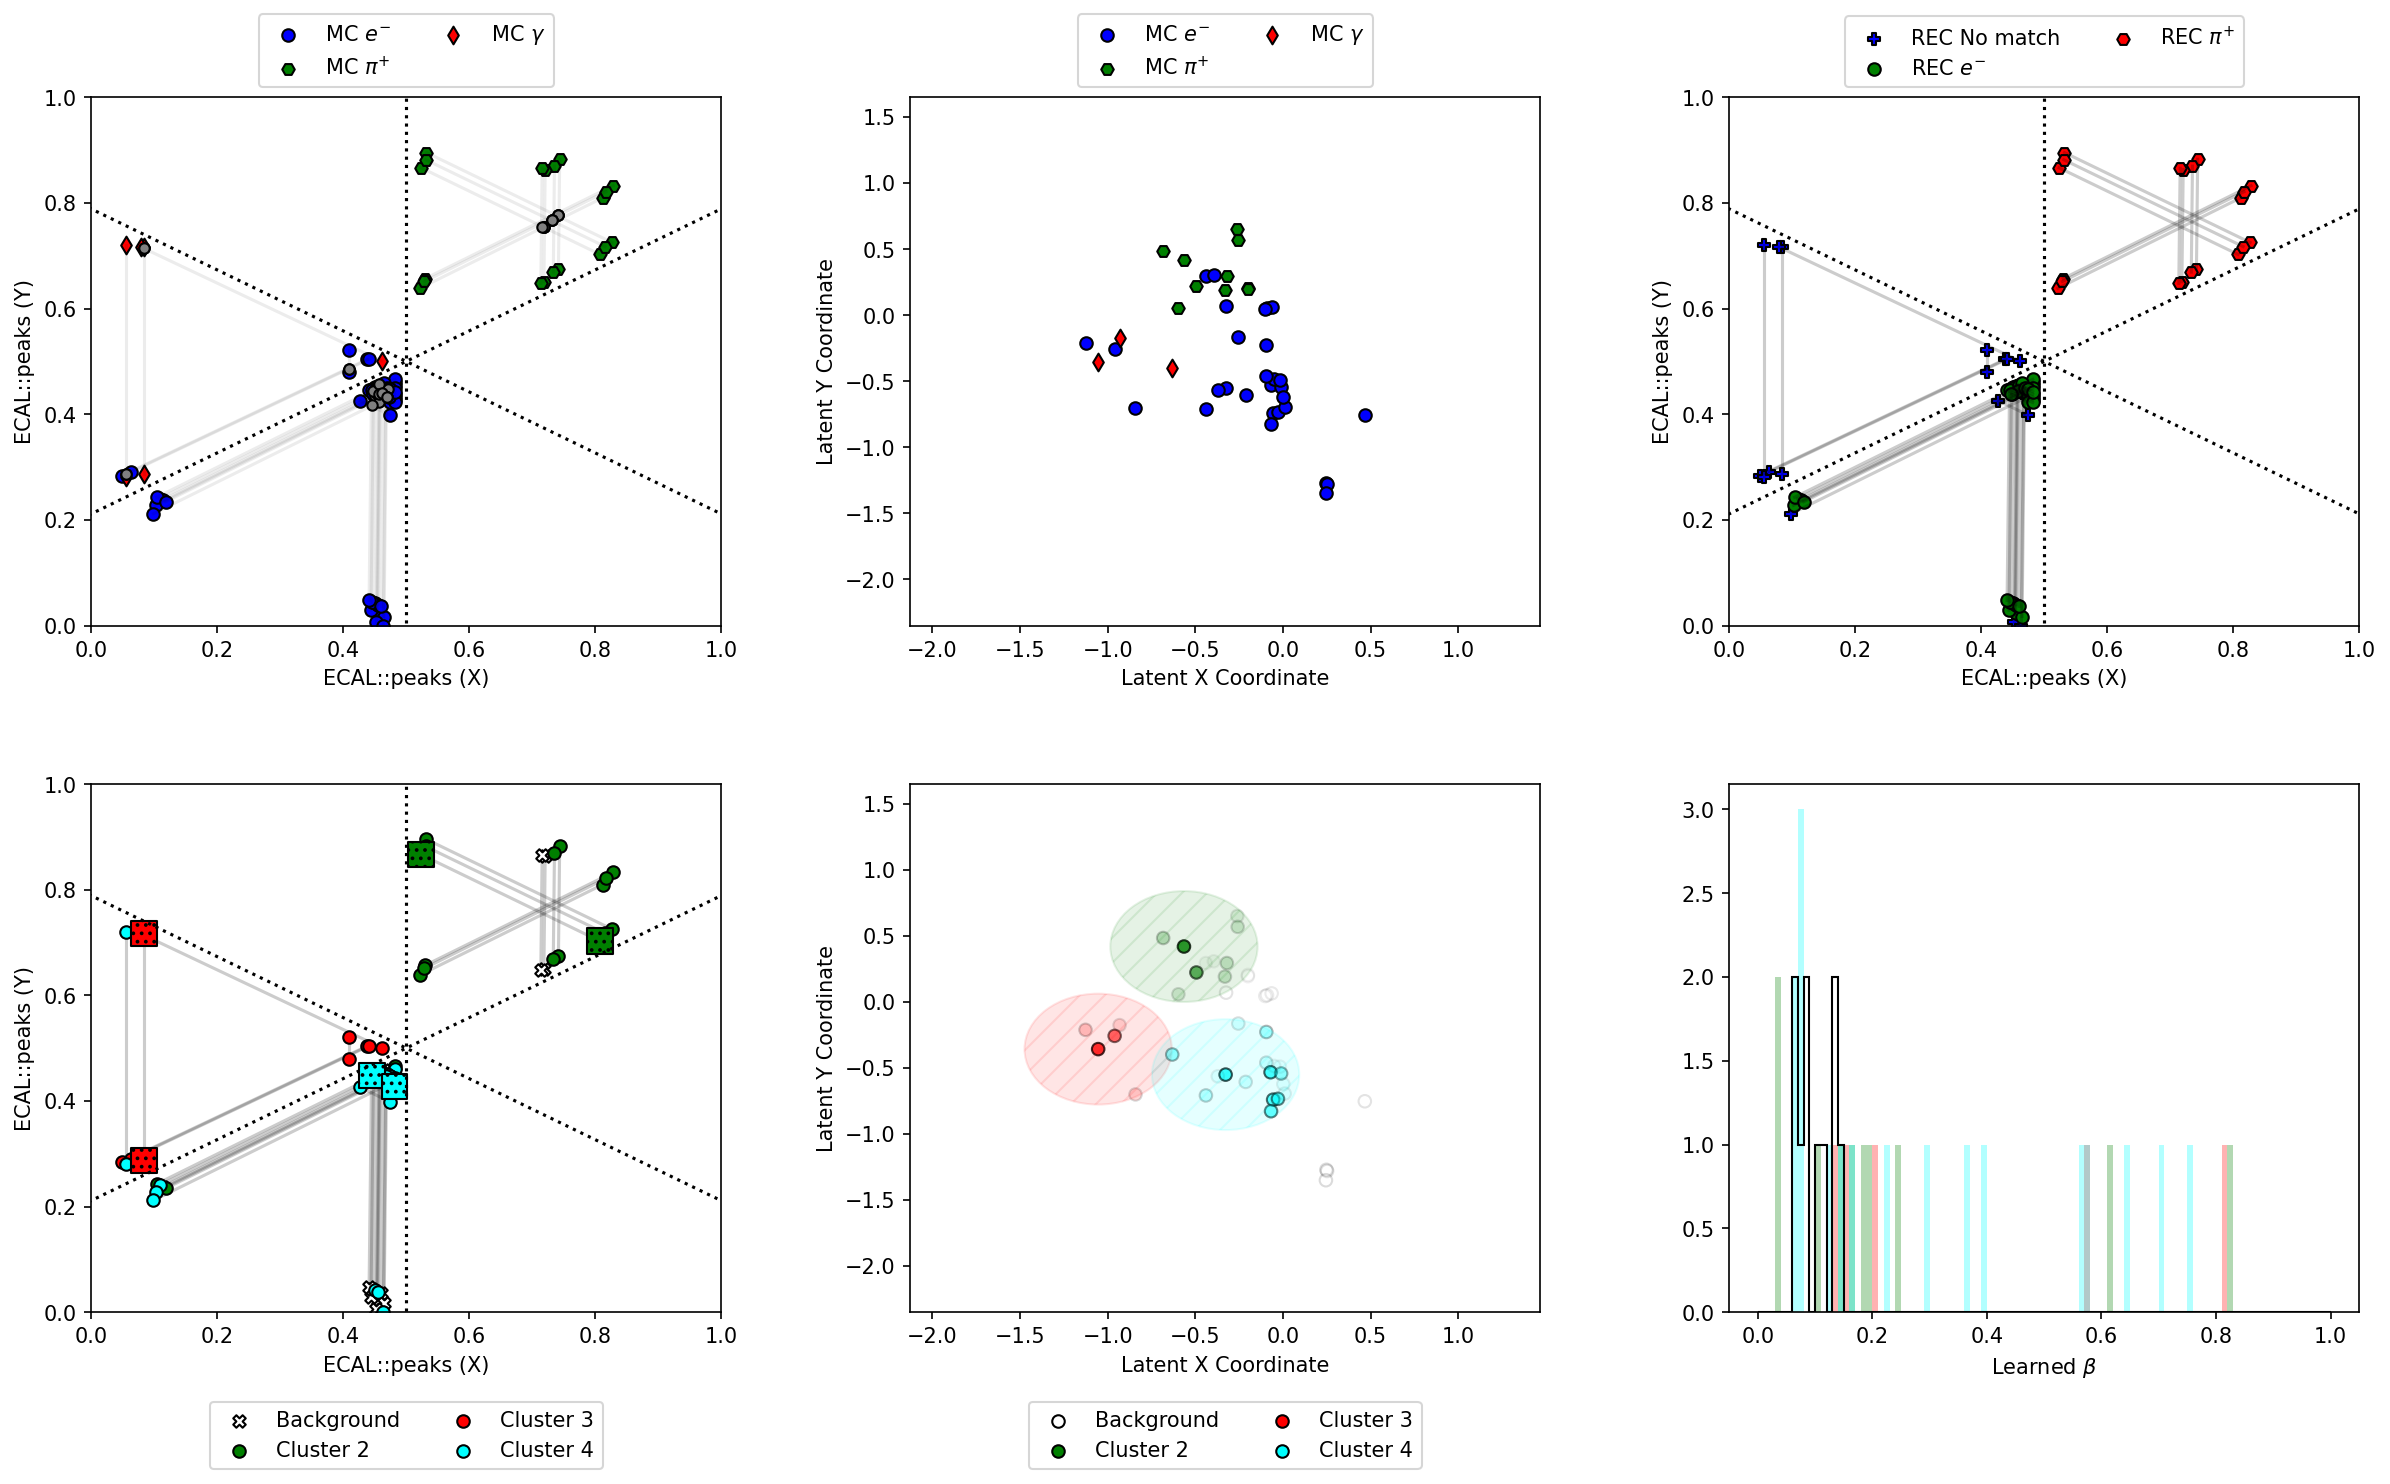

In [8]:
plotter = ModelEcalPlotter(evaluator.get_event_dataframe(
                                                        ))
plotter.plot_all(tD=evaluator.tD)

In [7]:
create_gif_from_pngs(outdir,"training.fast",duration=60)
create_gif_from_pngs(outdir,"training.slow",duration=500)

GIF saved at: ./out/08_28_2024_0026/training.fast_ev0.png.gif
GIF saved at: ./out/08_28_2024_0026/training.fast_ev1.png.gif
GIF saved at: ./out/08_28_2024_0026/training.fast_ev2.png.gif
GIF saved at: ./out/08_28_2024_0026/training.fast_ev3.png.gif
GIF saved at: ./out/08_28_2024_0026/training.fast_ev4.png.gif
GIF saved at: ./out/08_28_2024_0026/training.fast_ev5.png.gif
GIF saved at: ./out/08_28_2024_0026/training.fast_ev6.png.gif
GIF saved at: ./out/08_28_2024_0026/training.fast_ev7.png.gif
GIF saved at: ./out/08_28_2024_0026/training.fast_ev8.png.gif
GIF saved at: ./out/08_28_2024_0026/training.fast_ev9.png.gif
GIF saved at: ./out/08_28_2024_0026/training.slow_ev0.png.gif
GIF saved at: ./out/08_28_2024_0026/training.slow_ev1.png.gif
GIF saved at: ./out/08_28_2024_0026/training.slow_ev2.png.gif
GIF saved at: ./out/08_28_2024_0026/training.slow_ev3.png.gif
GIF saved at: ./out/08_28_2024_0026/training.slow_ev4.png.gif
GIF saved at: ./out/08_28_2024_0026/training.slow_ev5.png.gif
GIF save

In [21]:
loss_dict = {}
loc_dict  = {}

for e in range(0,64):

    # Extract the specific event data
    X_event = train_X[e:e+1]
    y_event = train_y[e:e+1]
    misc_event = train_misc[e:e+1]

    mask = y_event[:,:,0][0]==-1
    # Perform a forward pass to get the model's predictions
    y_pred_event = model.predict(X_event)
    xc = y_pred_event[:,:,1][0]
    yc = y_pred_event[:,:,2][0]
    xc = xc[~mask]
    yc = yc[~mask]
    # Calculate latent space coordinates of event
    loc_dict[f"ev_{e}"] = {"x": xc,
                           "y": yc,
                           "xc": np.mean(xc),
                           "yc": np.mean(yc),
                           "oxc": np.std(xc),
                           "oyc": np.std(yc)}
    
    loss = calculate_losses(y_event,y_pred_event,q_min)
    # Calculate the loss using the custom loss function
    att_loss = loss['attractive']
    rep_loss = loss['repulsive']
    cow_loss = loss['coward']
    nse_loss = loss['noise']
    
    loss_dict[f"ev_{e}"] = {"att":att_loss.numpy(),
                            "rep":rep_loss.numpy(),
                            "cow":cow_loss.numpy(),
                            "nse":nse_loss.numpy()}
    

In [24]:
pd.set_option('display.max_rows', 500)
df_loss = pd.DataFrame(loss_dict).transpose()
display(df_loss)

,att,rep,cow,nse
ev_0,1.670153,0.007187,0.016568,0.048811
ev_1,18.301016,0.555302,0.076079,0.048811
ev_2,1.669094,0.547017,0.924255,0.048811
ev_3,0.589910,0.108494,0.125434,0.048811
ev_4,0.743858,0.270812,0.574527,0.048811
ev_5,1.996853,0.462075,0.053110,0.048811
ev_6,2.401374,0.604347,0.043912,0.048811
ev_7,0.818181,0.081323,0.071855,0.048811
ev_8,1.400597,0.188005,0.046928,0.048811
ev_9,2.192929,0.489519,0.051763,0.048811


In [48]:
train_X[0]

<tf.Tensor: shape=(100, 29), dtype=float32, numpy=
array([[0.05428043, 0.49810982,        nan, ..., 0.        , 0.        ,
        1.        ],
       [0.05026212, 0.4975339 ,        nan, ..., 0.        , 0.        ,
        1.        ],
       [0.04250493, 0.5684669 ,        nan, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)>